# Data preparation

This notebook contains the code for data loading, preparation and chunking.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import re

from datasets import load_dataset

import nltk
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

In [27]:
squad = load_dataset("squad")

In [28]:
train_squad = squad["train"]
val_squad = squad["validation"]

In [29]:
train_df = train_squad.to_pandas()
val_df = val_squad.to_pandas()

In [30]:
train_df['answer_len'] = train_df['answers'].apply(lambda x: len(x['text']) if len(x['text']) > 0 else 0)
train_df[train_df['answer_len']>1].shape

(0, 6)

In [34]:
train_df.shape

(87599, 8)

In [31]:
train_df['context_id'] = train_df['context'].astype('category').cat.codes
context_df = train_df[['context_id', 'context', 'title']].drop_duplicates().reset_index(drop=True)
queries_df = train_df[['context_id', 'question', 'answers']]
queries_df['answer_text'] = queries_df['answers'].apply(lambda x: x['text'] if len(x['text']) > 0 else '')
queries_df['answer_start'] = queries_df['answers'].apply(lambda x: x['answer_start'] if len(x['answer_start']) > 0 else -1)
del queries_df['answers']

<Axes: >

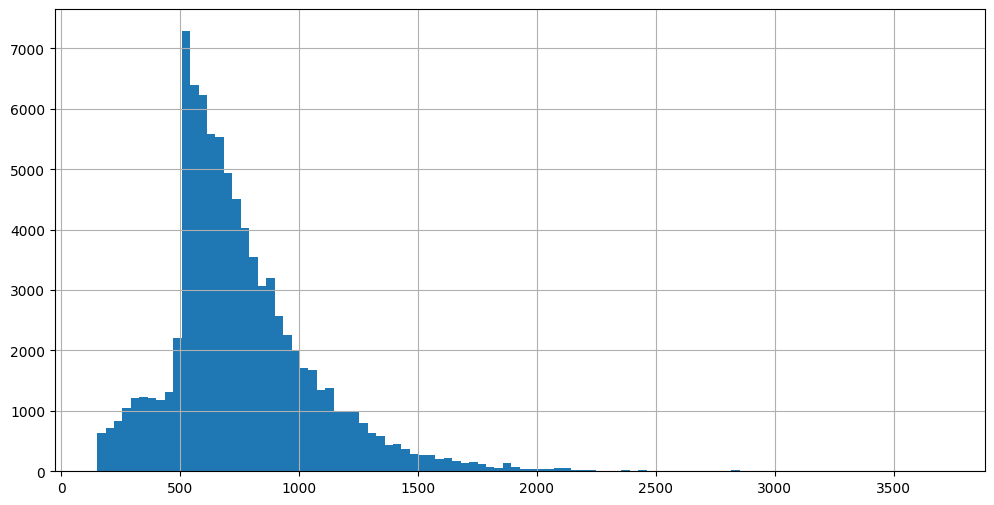

In [32]:
train_df['len_context'] = train_df['context'].apply(lambda x: len(x))

train_df['len_context'].hist(bins=100, figsize=(12,6))

In [13]:
train_df['len_context'].describe()

count    87599.000000
mean       754.364216
std        307.396264
min        151.000000
25%        559.000000
50%        693.000000
75%        895.000000
max       3706.000000
Name: len_context, dtype: float64

In [19]:
val_df['context_id'] = val_df['context'].astype('category').cat.codes
context_df_val = val_df[['context_id', 'context', 'title']].drop_duplicates().reset_index(drop=True)
queries_df_val = val_df[['context_id', 'question', 'answers']]
queries_df_val['answer_text'] = queries_df_val['answers'].apply(
    lambda x: x['text'][0] if isinstance(x['text'], (list, np.ndarray)) and len(x['text']) > 0 else ''
)
queries_df_val['answer_start'] = queries_df_val['answers'].apply(
    lambda x: x['answer_start'][0] if isinstance(x['answer_start'], (list, np.ndarray)) and len(x['answer_start']) > 0 else -1
)
del queries_df_val['answers']

In [20]:
# ---------- Coreference Resolution Stub ----------
def apply_coreference(text):
    return text

In [34]:
# ---------- Sentence Cleaning ----------
def clean_text(text: str) -> str:
    # Remove unwanted characters
    text = re.sub(r"[^a-zA-Z0-9.,;!?\'\"()\/\-\:$% ]+", " ", text)
    # Collapse multiple spaces/newlines/tabs into one
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [35]:
# ---------- Sliding Window Chunking ----------
def sliding_window_chunks(text, chunk_size=300, stride=100):
    chunks = []
    start = 0
    while start < len(text):
        end = min(start + chunk_size, len(text))
        chunks.append((text[start:end], start, end))
        if end == len(text):
            break
        start += stride
    return chunks

In [36]:
# ---------- Semantic Chunking ----------
model = SentenceTransformer("all-MiniLM-L6-v2")

def semantic_chunks(text, sim_threshold=0.6, max_chunk_size=500):
    sentences = sent_tokenize(text)
    # compute char offsets robustly
    offsets = []
    pos = 0
    for s in sentences:
        start = text.find(s, pos)
        if start == -1:
            start = pos
        end = start + len(s)
        offsets.append((s, start, end))
        pos = end

    if not offsets:
        return []

    sents = [s for (s, _, _) in offsets]
    emb = model.encode(sents, convert_to_tensor=True)
    chunks = []
    cur_sents = [offsets[0]]
    prev_emb = emb[0]

    for i in range(1, len(offsets)):
        sent, st, ed = offsets[i]
        cur_emb = emb[i]
        sim = util.cos_sim(prev_emb, cur_emb).item()
        cur_text_len = offsets[i][2] - offsets[i - len(cur_sents)][1]

        if sim >= sim_threshold and cur_text_len <= max_chunk_size:
            cur_sents.append(offsets[i])
        else:
            start_char = cur_sents[0][1]
            end_char = cur_sents[-1][2]
            chunk_text = text[start_char:end_char]
            chunks.append((chunk_text, start_char, end_char))
            cur_sents = [offsets[i]]
        prev_emb = cur_emb

    if cur_sents:
        start_char = cur_sents[0][1]
        end_char = cur_sents[-1][2]
        chunks.append((text[start_char:end_char], start_char, end_char))

    return chunks


In [37]:
# ---------- Build Chunk DataFrame ----------
def build_chunk_df(df, chunk_func, coref=False, **kwargs):
    all_chunks = []

    for idx, row in tqdm(df.iterrows()):
        orig_context = row["context"]
        context = orig_context
        if coref:
            # For embeddings: resolved text; offsets stay on orig_context
            resolved_context = apply_coreference(orig_context)
            context_for_offsets = orig_context
            context_for_embedding = resolved_context
        else:
            context_for_offsets = orig_context
            context_for_embedding = orig_context

        chunks_offsets = chunk_func(context_for_offsets, **kwargs)

        for i, (chunk_text, start, end) in enumerate(chunks_offsets):
            # chunk text for embedding (coref-resolved if coref=True)
            chunk_embed_text = context_for_embedding[start:end]

            chunk_text = clean_text(chunk_text)
            chunk_embed_text = clean_text(chunk_embed_text)

            all_chunks.append({
                "context_id": row["context_id"],
                "chunk_id": f"{row["context_id"]}_{i}",
                "chunk_text": chunk_text,
                "chunk_embed_text": chunk_embed_text,
                "title": row.get("title", ""),
                "chunk_start": start,
                "chunk_end": end,
                "coref": coref,
                "chunking_type": chunk_func.__name__
            })

    return pd.DataFrame(all_chunks)

In [38]:
df_sliding_train = build_chunk_df(context_df, sliding_window_chunks, coref=False, chunk_size=300, stride=200)
df_sliding_val = build_chunk_df(context_df_val, sliding_window_chunks, coref=False, chunk_size=300, stride=200)

18891it [00:01, 12999.40it/s]
2067it [00:00, 12237.13it/s]


In [62]:
df_semantic_train = build_chunk_df(context_df, semantic_chunks, coref=False, sim_threshold=0.6, max_chunk_size=500)
df_semantic_val = build_chunk_df(context_df_val, semantic_chunks, coref=False, sim_threshold=0.6, max_chunk_size=500)

18891it [05:43, 55.00it/s]
2067it [00:38, 53.05it/s]


In [ ]:
#df_sliding_coref = build_chunk_df(train_df, sliding_window_chunks, coref=True, chunk_size=300, stride=100)
#df_semantic_coref = build_chunk_df(train_df, semantic_chunks, coref=True, sim_threshold=0.6, max_chunk_size=500)

In [63]:
# ---------- Quick Check ----------
print("Sliding train:", df_sliding_train.shape)
print("Semantic train:", df_semantic_train.shape)
#print("Sliding+Coref:", df_sliding_coref.shape)
#print("Semantic+Coref:", df_semantic_coref.shape)

Sliding train: (70068, 9)
Semantic train: (84007, 9)


In [64]:
df_semantic_train.head(3)

,context_id,chunk_id,chunk_text,chunk_embed_text,title,chunk_start,chunk_end,coref,chunking_type
0,1683,1683_0,"Architecturally, the school has a Catholic cha...","Architecturally, the school has a Catholic cha...",University_of_Notre_Dame,0,53,False,semantic_chunks
1,1683,1683_1,Atop the Main Building's gold dome is a golden...,Atop the Main Building's gold dome is a golden...,University_of_Notre_Dame,54,127,False,semantic_chunks
2,1683,1683_2,Immediately in front of the Main Building and ...,Immediately in front of the Main Building and ...,University_of_Notre_Dame,128,270,False,semantic_chunks


In [65]:
df_semantic_train.to_excel("./data/prepared/squad_train_v2_semantic_chunking.xlsx", index=False)
df_semantic_val.to_excel("./data/prepared/squad_val_v2_semantic_chunking.xlsx", index=False)

In [66]:
queries_df.to_excel("./data/prepared/squad_train_v2_queries.xlsx", index=False)
queries_df_val.to_excel("./data/prepared/squad_val_v2_queries.xlsx", index=False)